# Tree-Based Models for Mortality Prediction in FHS: First Imputed Dataset

## Setup

### Importing libraries

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Importing Data + Preprocessing

In [6]:
df = pd.read_csv(r'C:\Users\danie\Desktop\CICOM\FHS_medi\fhs_imp_1_pyth.csv') # change this input file to test on other imputed datset, then run whole file again
df.head()

,AGE,SEX,SYSBP,DIABP,CURSMOKE,CIGPDAY,HEARTRTE,educ,PREVCHD,PREVAP,...,HOSPMI,MI_FCHD,STROKE,CVD,ANYCHD,HYPERTEN,BMI,DIABETES,DEATH,label
0,52,1,121.0,66.0,0,0,69,4,0,0,...,1,1,0,1,1,0,24.85,0,0,test
1,58,2,108.0,66.0,0,0,80,2,0,0,...,0,0,0,0,0,0,28.50,0,0,test
2,54,1,141.0,89.0,1,30,75,1,0,0,...,0,0,0,0,0,0,25.34,0,0,train
3,67,2,183.0,109.0,1,20,60,3,0,0,...,0,0,1,1,0,1,30.18,0,1,test
4,58,2,155.0,90.0,1,30,74,3,0,0,...,0,0,0,0,0,1,24.61,0,0,train


In [7]:
# pre-processing: Converted certain variables to factors
categorical_vars = ['SEX', 'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'ANGINA',
       'HOSPMI', 'MI_FCHD', 'STROKE', 'CVD', 'ANYCHD', 'HYPERTEN',
       'DIABETES', 'DEATH']
for col in categorical_vars:
    df[col] = df[col].astype('category')

# pre-processing: Robust Scaler -  more robust to outliers
scaler = preprocessing.RobustScaler()
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Train-Test Split (80/20)
trains = df[df['label'] == 'train']
tests = df[df['label'] == 'test']

# splitting predictor and label
X_train = trains.drop(['DEATH', 'label'], axis=1)
y_train = trains['DEATH']
X_test = tests.drop(['DEATH', 'label'], axis=1)
y_test = tests['DEATH']

## Model Metrics Helper Function
- outputs the auc, threshold, accuracy, sensitivity, and specificity
- arguments: fitted model object, predictor portion of dataset, target variable portion of datset, file export name
- optional boolean argument to output a dataframe with the above results

In [14]:
def model_metrics(model_obj, dataset_x, dataset_y, exp_name, mod_name, df_out = True):
    y_pred_probs = model_obj.predict_proba(dataset_x)[:,1]
    auc_score = roc_auc_score(dataset_y, y_pred_probs)
    
    # finding the best threshold
    fpr, tpr, thresholds = roc_curve(dataset_y, y_pred_probs)
    best_index = np.argmax(tpr - fpr) 
    best_threshold = thresholds[best_index]
    
    # outputting confusion matrix
    y_preds_optim = y_pred_probs >= best_threshold
    y_preds_optim = y_preds_optim.astype(int)
    cm_rf = confusion_matrix(dataset_y, y_preds_optim)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Class 0", "Class 1"]) # Adjust labels as needed
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()
    
    # outputting the model assessment metrics
    print('Model Metrics')
    tn, fp, fn, tp = confusion_matrix(dataset_y, y_preds_optim).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)
    precision = tp / (fp + tp)
    neg_pred_value = tn / (fn + tn)
    acc  = (tp + tn) / (tn + fp + fn + tp)
    
    print('AUC: ', round(auc_score*100,2))
    print('Accuracy: ', round(acc*100,2))
    print('Sensitivity: ', round(sensitivity*100,2))
    print('Specificity: ', round(specificity*100,2))
    print('Precision: ', round(precision*100,2))
    print('Negative Predictive Value: ', round(neg_pred_value*100,2))

   
    results_df = {'Model Name' : [mod_name],
         'AUC': [round(auc_score,3)],
         'Threshold': [round(best_threshold, 3)],
         'Accuracy' : [round(acc, 3)],
         'Sensitivity' : [round(sensitivity, 3)],
         'Specificity' : [round(specificity, 3)]}

    df_res = pd.DataFrame(results_df)
    if (df_out):
        df_res.to_csv(exp_name, index=False)

    return(df_res)

## Random Forest

#### Optimizing using Grid Search CV

Paper for setting the grid: https://ieeexplore.ieee.org/abstract/document/8947569?casa_token=mzR6aCijVwUAAAAA:HFgC7dvVYAOLHI4Rkx2-nxKIE0TaNZAakjeARGKuXVrGwELLyupr3ebdDxyUXjgRx-F0aXsnMxk

- recommends number of trees between 20 to 100, and increasing to 150 for datasets with more than 500k observations
- number of features should be between between 2 and 0.7*maxFeatures
- tree depth should be between 2 to 0.7*maxFeatures
- the minimum number of objects in each leaf should be from 1 to 50
- But these datsets were very large, though they had imbalanced case/outcome, like in our dataset

In [16]:
param_grid = {
    'n_estimators': [x for x in range(20,110,10)],
    'max_features' : [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'max_depth': [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'criterion': ['gini', 'entropy'] # omit log loss because it is too sensitive to imbalance
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)



C:\Users\danie\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 6, 'n_estimators': 70}
Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=14, max_features=6,
                       n_estimators=70, random_state=123)


#### Fitting the Optimized Model

In [26]:
model_grid = RandomForestClassifier(max_depth=grid_search.best_params_['max_depth'],
                                        max_features=grid_search.best_params_['max_features'],
                                        n_estimators=grid_search.best_params_['n_estimators'],
                                        criterion=grid_search.best_params_['criterion'],
                                        random_state=123)
model_grid.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=6,
                       n_estimators=70, random_state=123)

#### Model Metrics on Training Split

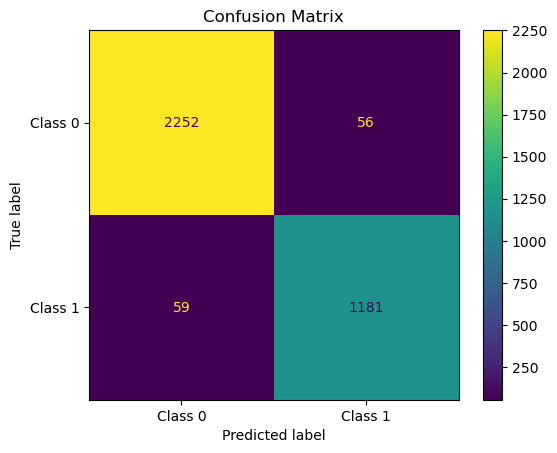

Model Metrics
AUC:  99.47
Accuracy:  96.76
Sensitivity:  95.24
Specificity:  97.57
Precision:  95.47
Negative Predictive Value:  97.45


In [30]:
train_rf = model_metrics(model_grid, X_train, y_train, 'train_rf_res_imp1_copy.csv', mod_name = 'Random Forest', df_out = False)

#### Model Metrics on the Test Dataset

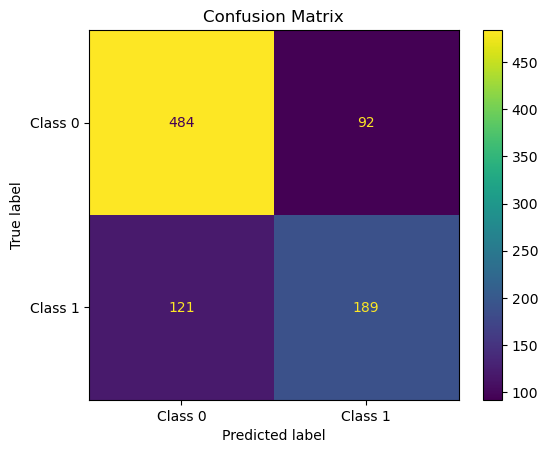

Model Metrics
AUC:  78.4
Accuracy:  75.96
Sensitivity:  60.97
Specificity:  84.03
Precision:  67.26
Negative Predictive Value:  80.0


In [34]:
test_rf = model_metrics(model_grid, X_test, y_test, 'test_rf_res_imp1_copy.csv', mod_name = 'Random Forest', df_out = False)

#### Feature Importance Values

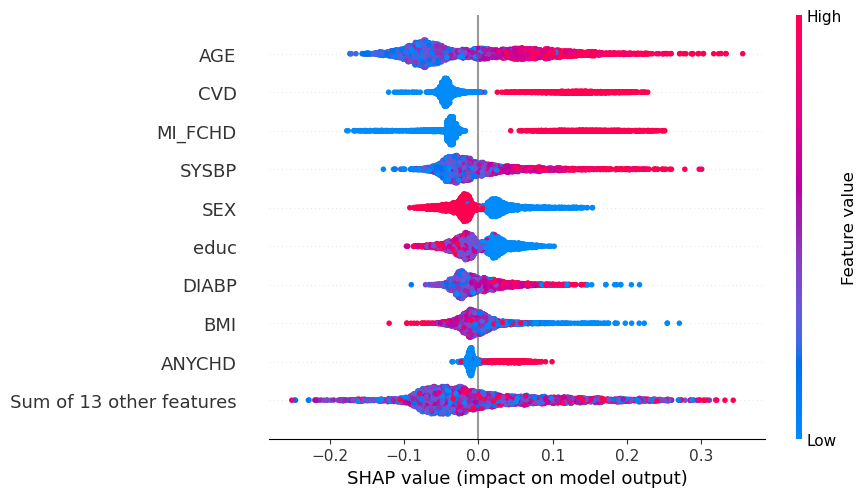

In [36]:
# SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model_grid)

# SHAP on train set
shap_values = explainer(X_train)

# plotting the SHAP values
shap.plots.beeswarm(shap_values[:,:,1])

## Xgboost

#### Finding Optimal Hyperparameters

In [37]:
param_grid_xgb = {
    'max_depth': [x for x in range(2,round(0.7*len(X_train.columns))+1)],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier(random_state=123, enable_categorical=True, eval_metric='auc')

# Create the GridSearchCV object
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)

# Fit the GridSearchCV object to the training data
grid_xgb.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}
Best score:  0.7756459206579392


#### Fitting optimized model

In [38]:
xgb_opt = xgb.XGBClassifier(max_depth=3,
                            learning_rate=0.1,
                            subsample=0.5,
                            enable_categorical=True,
                            random_state=123)
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Model Metrics on Training Split

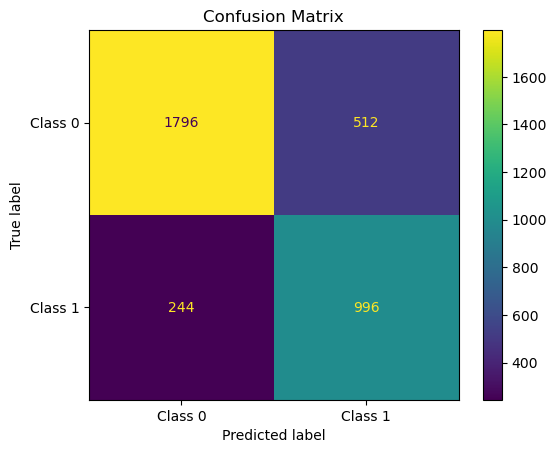

Model Metrics
AUC:  86.51
Accuracy:  78.69
Sensitivity:  80.32
Specificity:  77.82
Precision:  66.05
Negative Predictive Value:  88.04


In [39]:
train_xgb = model_metrics(xgb_opt, X_train, y_train, 'train_xgb_res_imp1_copy.csv', mod_name = 'XGBoost', df_out = False)

#### Model Metrics on the Test Split

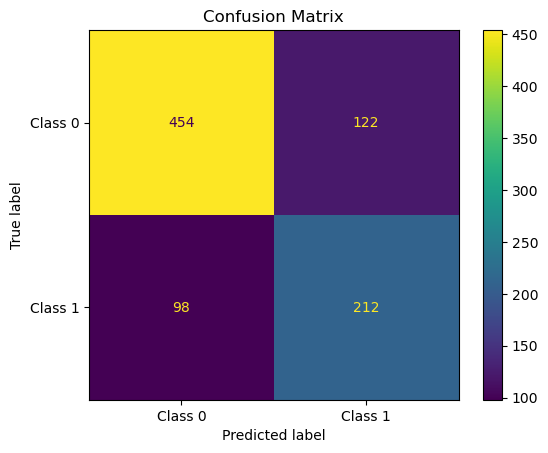

Model Metrics
AUC:  79.6
Accuracy:  75.17
Sensitivity:  68.39
Specificity:  78.82
Precision:  63.47
Negative Predictive Value:  82.25


In [40]:
test_xgb = model_metrics(xgb_opt, X_test, y_test, 'test_xgb_res_imp1_copy.csv', mod_name = 'XGBoost', df_out = False)

#### Feature Importance

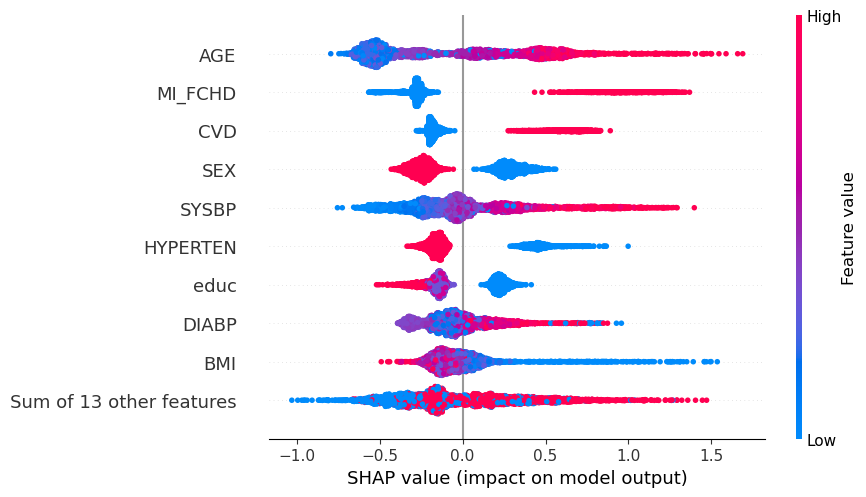

In [41]:
# SHAP explainer for the Random Forest model
explainer_xgb = shap.TreeExplainer(xgb_opt)

# SHAP on train set
shap_values_xgb = explainer_xgb(X_train)

# plotting the SHAP values
shap.plots.beeswarm(shap_values_xgb)

# Results Collection

In [50]:
combined_df = pd.concat([train_rf, test_rf, train_xgb, test_xgb], axis=0)
combined_df['Dataset Used'] = ['train', 'test', 'train', 'test']
combined_df

,Model Name,AUC,Threshold,Accuracy,Sensitivity,Specificity,Dataset Used
0,Random Forest,0.995,0.346,0.968,0.952,0.976,train
0,Random Forest,0.784,0.447,0.760,0.610,0.840,test
0,XGBoost,0.865,0.319,0.787,0.803,0.778,train
0,XGBoost,0.796,0.382,0.752,0.684,0.788,test
